In [ ]:
import math
import importlib

import pickle
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from ax import Client, RangeParameterConfig

from botorch.models import SingleTaskGP
from botorch.acquisition import qLogExpectedImprovement, qMaxValueEntropy

from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.priors import GammaPrior

from src.ax_helper import get_full_strategy
from src import GPVisualiser, ax_helper
from src.ax_helper import get_guess_coords
import logging
from src.ax_helper import silence_ax_client, get_full_strategy
from src.toy_functions import Hartmann6D
import pickle

silence_ax_client()


-0.0 -0.9874311636230129


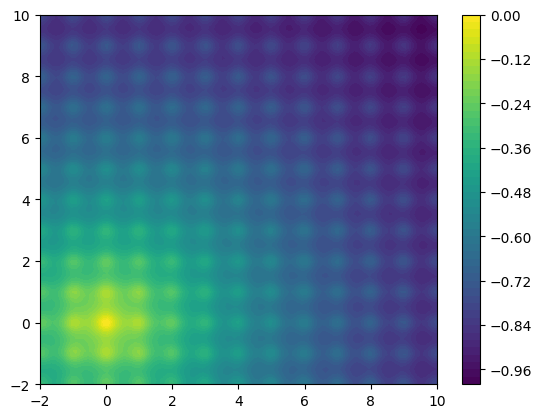

In [ ]:
range_parameters = [
    RangeParameterConfig(
        name="x1", parameter_type="float", bounds=(-2, 10)
    ),
    RangeParameterConfig(
        name="x2", parameter_type="float", bounds=(-2, 10)
    )
]

metric_name = "response"
dim_names = ["x1", "x2"]


def test_function(x1, x2):
    # Ackley function (commonly used for optimization benchmarks)
    a = 20
    b = 0.2
    c = 2 * math.pi
    sum_sq = 0.5 * (x1**2 + x2**2)
    cos_comp = 0.5 * (math.cos(c * x1) + math.cos(c * x2))
    ackley_grid = -a * math.exp(-b * math.sqrt(sum_sq)) - math.exp(cos_comp) + a + math.exp(1)
    standardized = (ackley_grid-0.2434339681166695)/(19.3680592868830)
    return -standardized


import numpy as np
grid = np.linspace(-2, 10, 101)
x1_grid, x2_grid = np.meshgrid(grid, grid)
ackley_vals = np.array([test_function(x1, x2) for x1, x2 in zip(x1_grid.ravel(), x2_grid.ravel())]).reshape(x1_grid.shape)
ackley_vals
print(ackley_vals.max(), ackley_vals.min())


plt.contourf(x1_grid, x2_grid, ackley_vals, levels=60, cmap="viridis")
plt.colorbar()

# Sobol
The default initial parameter exploration strategy uses SOBOL algorithm:

### log param sobol:

In [ ]:
import logging
import builtins

class SuppressInfoPrefix(logging.Filter):
    def filter(self, record):
        return not record.getMessage().startswith('[INFO')

# Create and register the filter globally (all loggers)
_filter = SuppressInfoPrefix()
root_logger = logging.getLogger()
root_logger.addFilter(_filter)
for handler in root_logger.handlers:
    handler.addFilter(_filter)

# Also add to any already-created loggers
for logger_name, lg in logging.root.manager.loggerDict.items():
    if isinstance(lg, logging.Logger):
        lg.addFilter(_filter)
        for h in lg.handlers:
            h.addFilter(_filter)

# Optional: suppress bare print() lines starting with '[INFO'
_original_print = builtins.print
def filtered_print(*args, **kwargs):
    if args and isinstance(args[0], str) and args[0].startswith('[INFO'):
        return
    _original_print(*args, **kwargs)

builtins.print = filtered_print


   trial_name         x0         x1
0         0_0  10.000000  10.000000
1         1_0   3.983191   6.912967
2         2_0  29.466361  28.029890
3         3_0  39.855483   1.227392
4         4_0   2.948200  49.868141
5         5_0   1.235331   2.073957
6         6_0  92.179993  90.971582
7         7_0  12.345972   3.690186
8         8_0   9.213090  16.148987
9         9_0   6.760385   1.671504
10       10_0  16.246561  41.230000
11       11_0  67.563837   9.405096
12       12_0   1.623795  23.145168
13       13_0   2.260619   5.569934
14       14_0  53.828891  12.700093
15       15_0  22.619623   3.127348
16       16_0   5.385755  71.452294
17       17_0   4.460701   2.477465
18       18_0  19.057398  56.612253
19       19_0  44.580526   4.408224
20       20_0   1.904725  10.049806
21       21_0   1.444788   7.717088
22       22_0  61.193687  18.993867
23       23_0  14.456433   1.370187
24       24_0   6.122615  33.792699
25       25_0   8.348627   3.497583
26       26_0  10.979456  15

<Axes: xlabel='x0', ylabel='x1'>

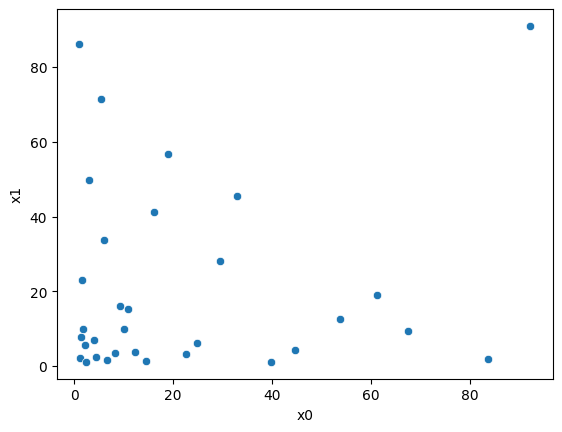

In [ ]:

client = Client()
client.verbose_logging = False
#client.verbose_logging = False

client.configure_experiment(
    name="batch_bo_test",
    parameters=[
        RangeParameterConfig(
            name=f"x{i}",
            bounds=(1, 100),
            parameter_type="float",
            scaling = 'log',
        ) for i in range(len(dim_names))
    ],
)

client.configure_optimization(objective="-loss")
client.get_next_trials(max_trials=32)
coords = get_guess_coords(client)
print(coords)
sns.scatterplot(data=coords, x="x0", y="x1")

Low value oversampling is inline with logarithmic distribution.

**Considering that we expect overexpression to be optimal when compared to underexpression, Sobol should be run on a linear scale**.

### linear parameters sobol

<Axes: xlabel='x1', ylabel='x2'>

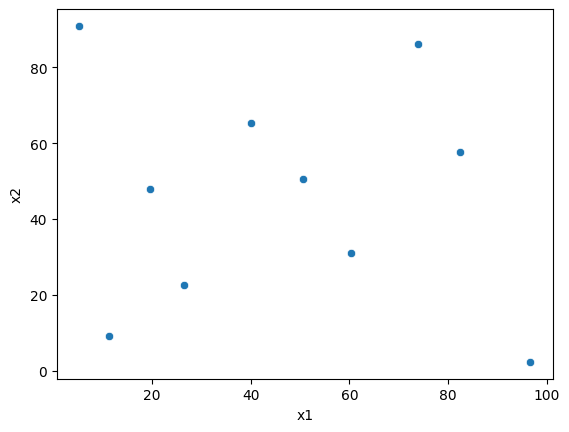

In [ ]:
client = Client()

parameters=[
    RangeParameterConfig(
        name=dim,
        bounds=(1, 100),
        parameter_type="float",
        # scaling = 'log',
    ) for dim in dim_names
]


client.configure_experiment(
    name="batch_bo_test",
    parameters=parameters
)

client.configure_optimization(objective="response")
client.get_next_trials(max_trials=10)

coords = get_guess_coords(client)

sns.scatterplot(data=coords, x="x1", y="x2")

A nice and informative initial guess grid is formed

c:\Users\326po\AppData\Local\pypoetry\Cache\virtualenvs\bo-coli-wM2eEb6D-py3.13\Lib\site-packages\botorch\models\utils\assorted.py:270: InputDataWarning:

Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.



(<Figure size 1200x600 with 2 Axes>,
 array([<Axes: title={'center': 'GP along x1'}, xlabel='x1', ylabel='response'>,
        <Axes: title={'center': 'GP along x2'}, xlabel='x2', ylabel='response'>],
       dtype=object))

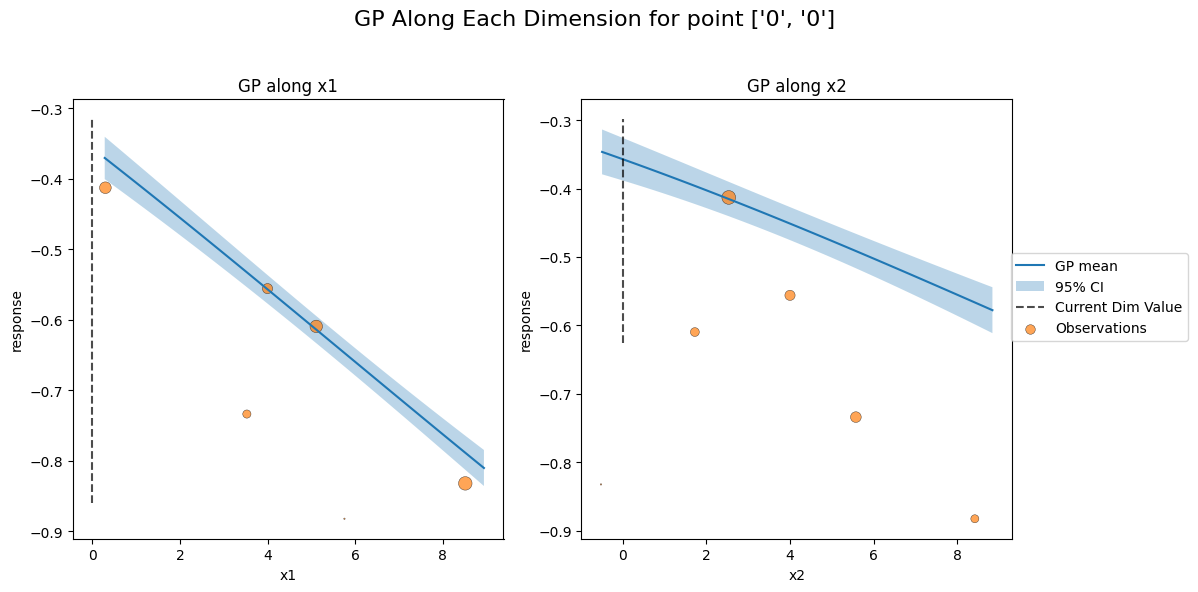

In [ ]:
client = Client()

client.configure_experiment(parameters=range_parameters)


client.configure_optimization(objective=metric_name)

from src import ax_helper
importlib.reload(ax_helper)

batch_handler = ax_helper.BatchClientHandler(client, test_function, dim_names, metric_name, batch_size=6, range_params=range_parameters)
batch_handler.get_next_batch()
batch_handler.complete_all_pending()

df = ax_helper.get_obs_from_client(client, response_col='response')
plotter = GPVisualiser.GPVisualiserMatplotlib(SingleTaskGP, df, dim_names, 'response', parameters)
plotter.plot_all([0,0])

In [7]:
df

,trial_name,x1,x2,response
0,0_0,4.000000,4.000000,-0.556069
1,1_0,8.518793,-0.524263,-0.832390
2,2_0,3.527637,5.576479,-0.734022
3,3_0,0.294786,2.534239,-0.412980
4,4_0,5.757527,8.423862,-0.882563
5,5_0,5.113390,1.722953,-0.609707


# Custom Botorch model

### Define the GP surrogate


MES (max value entropy search) should be the ideal choice for acquisition functions because:
* It can handle noise.
* Samples in a manner to best define the optimum.
    * Consequently, will rarely repeat exactly identical samplings.
* Has a cost/fidelity setting

In [ ]:
client = Client()
generation_strategy = get_full_strategy(gp=SingleTaskGP, acqf_class=qLogExpectedImprovement)
client.configure_experiment(parameters=range_parameters)

client.set_generation_strategy(
    generation_strategy=generation_strategy,
)
client.configure_optimization(objective=metric_name)

from src import ax_helper
importlib.reload(ax_helper)

batch_handler = ax_helper.BatchClientHandler(client, test_function, dim_names, metric_name, batch_size=1, range_params=range_parameters)
batch_handler.get_next_batch()
batch_handler.complete_all_pending()

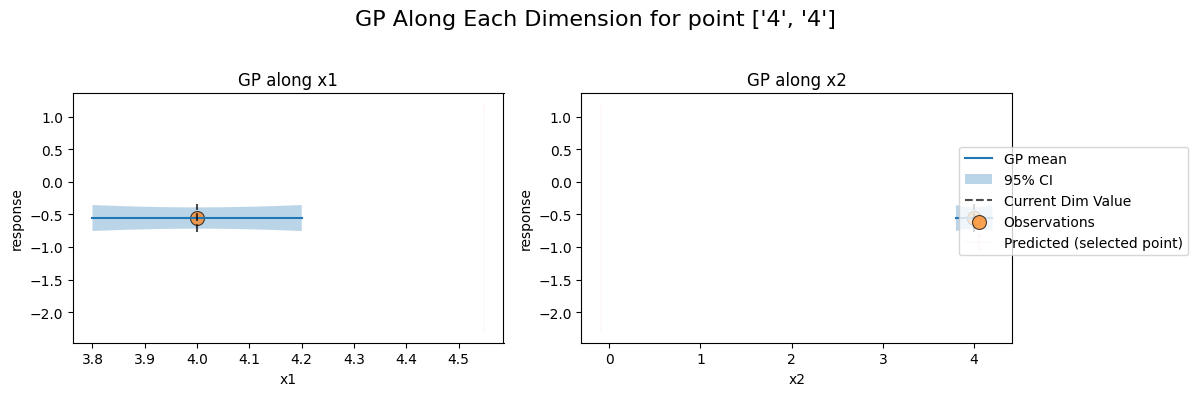

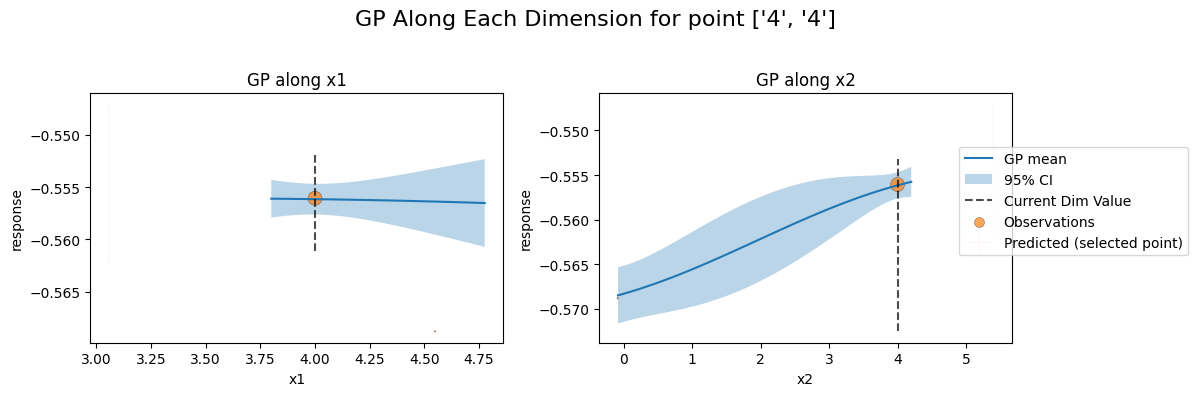

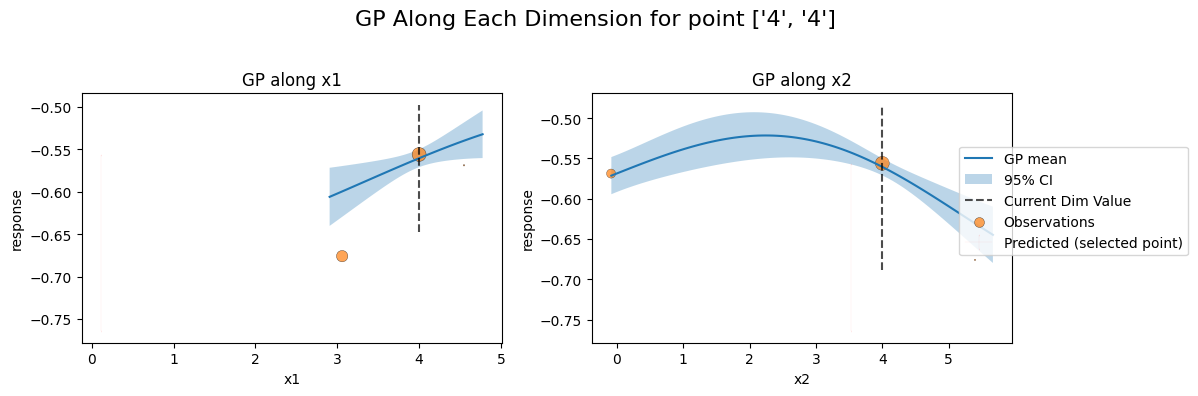

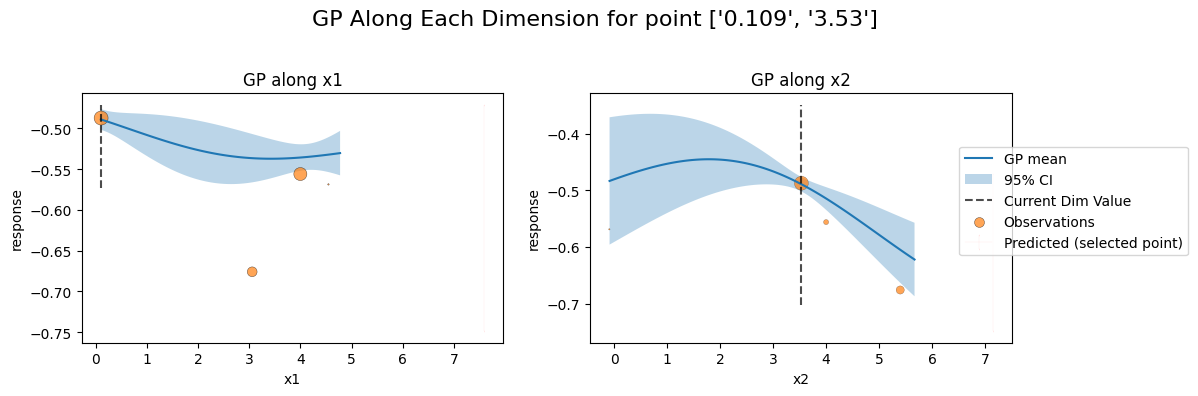

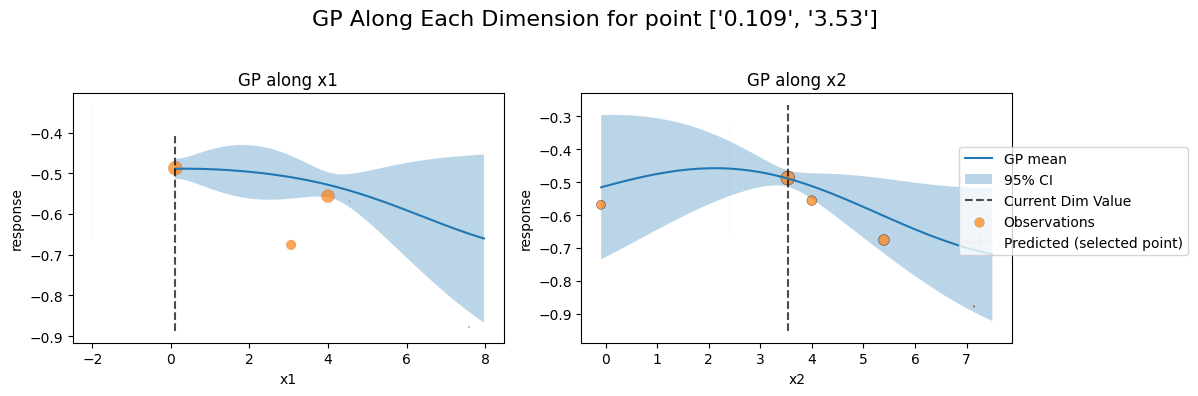

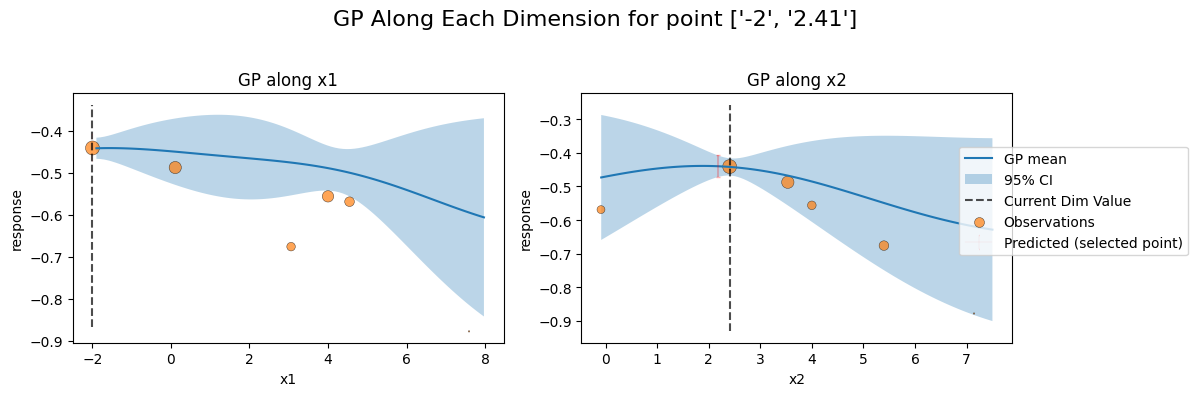

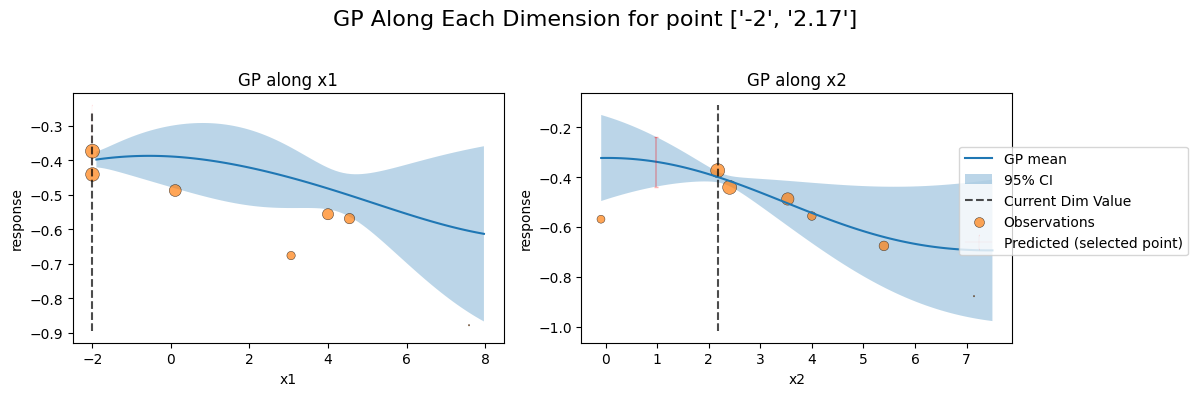

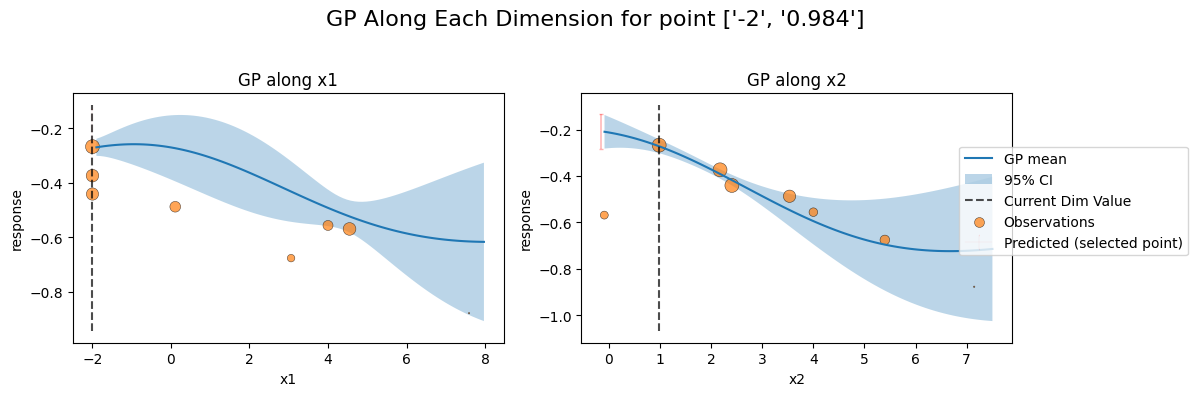

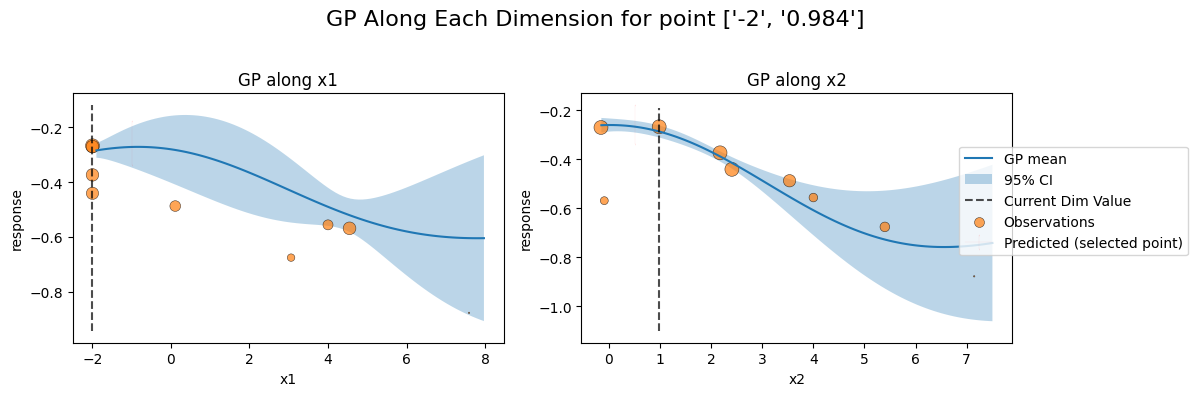

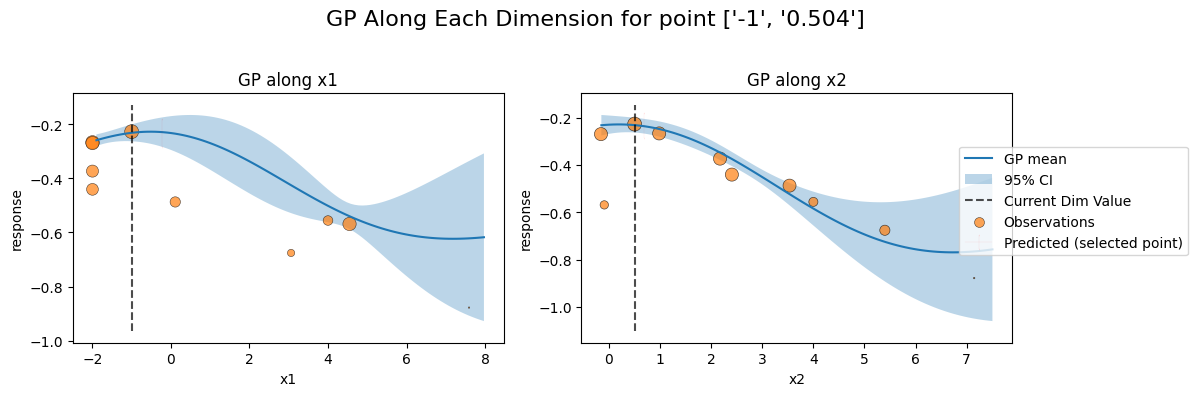

In [ ]:
import matplotlib.pyplot as plt
for _ in range(10):
    batch_handler.get_next_batch()

    batch_handler.plot_GP(SingleTaskGP, figsize=(12, 4))
    batch_handler.complete_all_pending()


In [10]:
df

,trial_name,x1,x2,response
0,0_0,4.000000,4.000000,-0.556069
1,1_0,8.518793,-0.524263,-0.832390
2,2_0,3.527637,5.576479,-0.734022
3,3_0,0.294786,2.534239,-0.412980
4,4_0,5.757527,8.423862,-0.882563
5,5_0,5.113390,1.722953,-0.609707


# Technical repeats
Knowing that real biological data posses significant significant noise, the model has to be robust enough to handle technical repeats

In [ ]:
range_parameters = [
    RangeParameterConfig(
        name="x1", parameter_type="float", bounds=(-2, 10)
    )
]

metric_name = "response"
dim_names = ["x1"]

def test_function(x1):
    # Original: y = -((x1 - 2) ** 2) + 10  -> range on [-2,10] is [-54, 10]
    y = -((x1 - 2) ** 2) + 10
    return (y + 54) / 64  # scale to [0,1]


noise_fn = lambda x: x + np.random.normal(0, 1)

def plot_test():
    plt.plot(np.linspace(-2, 10, 100), [test_function(x) for x in np.linspace(-2, 10, 100)], color='black', label='True function')

In [ ]:
from src.ax_helper import SequentialRuns
SequentialRuns

src.ax_helper.SequentialRuns

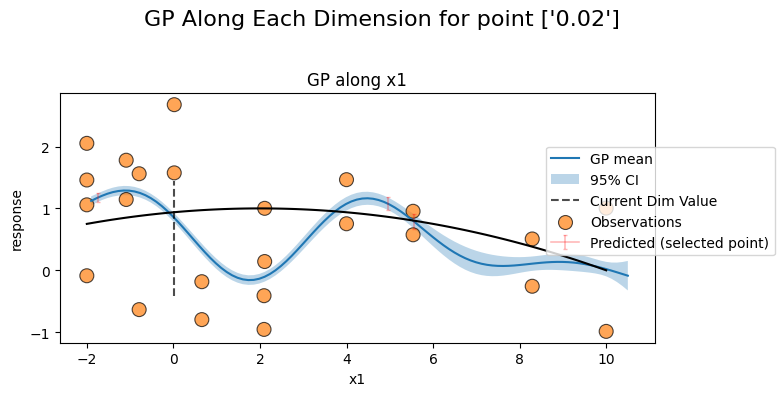

In [13]:
tester = SequentialRuns(test_function, range_parameters, dim_names, metric_name)

runs = tester.run(
    SingleTaskGP,
    n_runs=4,
    technical_repeats=2,
    batch_size=3,
    noise_fn=noise_fn,
    plot_each=False,
)
runs.plot_GP(SingleTaskGP, figsize=(8, 4))
plot_test()

* This simple Kernel is incapable of encompassing noise. Consequently, it overfits.
* Technical repeats slightly improve the situation, however they do not fix the problem.

### GP + noise

Simply adding a lot of noise, significantly improves the fit.
 

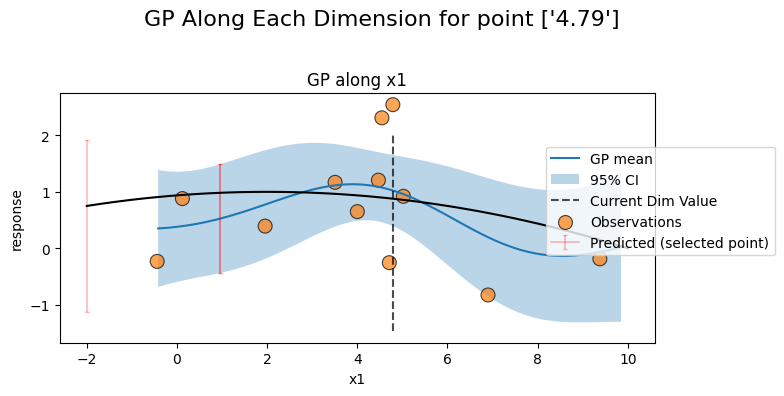

In [ ]:
from model_generation import GammaNoiseSGP


runs = tester.run(
    GammaNoiseSGP,
    n_runs=4,
    technical_repeats=1,
    batch_size=3,
    noise_fn=noise_fn,
    plot_each=False,
).plot_GP(GammaNoiseSGP, figsize=(8, 4))


plot_test()

* Introducing a noise channel significantly improves fit performance, even if no technical repeats are provided to narrow down the mean.
However,a heteroscedastic, or at least technical repeat aware noise kernel would be preferable.

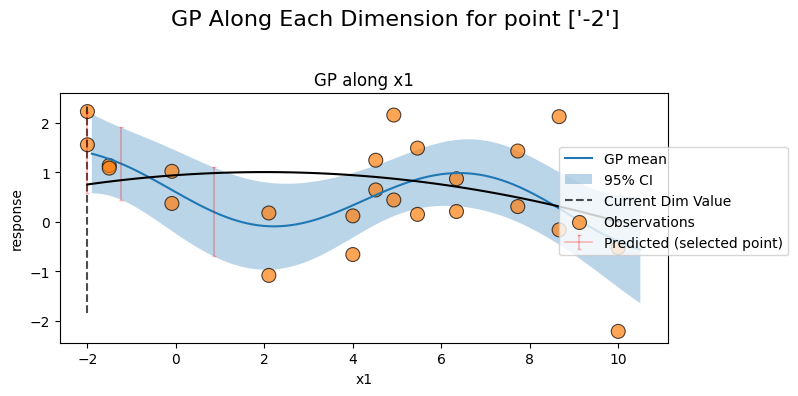

In [ ]:
runs = tester.run(GammaNoiseSGP, n_runs=4, technical_repeats=2, batch_size=3, noise_fn=noise_fn, plot_each=False).plot_GP(GammaNoiseSGP, figsize=(8, 4))
plot_test()

It appears that technical repeats significantly improve noise resolution for the kernel, however, more quantitative tests are required.

# Quantification of Noise, technical repeats, and batch size.

6 dimensional hartman function is used for evaluation, due to its high dimensionality, multiple local optima, ridges and non-linear interactions.

In [ ]:


save_dir = "data/bayes_sim/"
h6 = Hartmann6D().eval_at

_h6_x_opt = torch.tensor([0.20169, 0.150011, 0.476874, 0.275332, 0.311652, 0.6573])
h_6_max = [float(h6(*_h6_x_opt)) for _ in range(10000)]
h_6_max

[3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,


In [17]:
hartmann6_range_parameters = [
    RangeParameterConfig(name=f"x{i+1}", parameter_type="float", bounds=(0.0, 1.0))
    for i in range(6)
]
dim_names_h6 = [rp.name for rp in hartmann6_range_parameters]

tester = SequentialRuns(h6, hartmann6_range_parameters, dim_names_h6, metric_name)
tester

## Sequential runs no noise

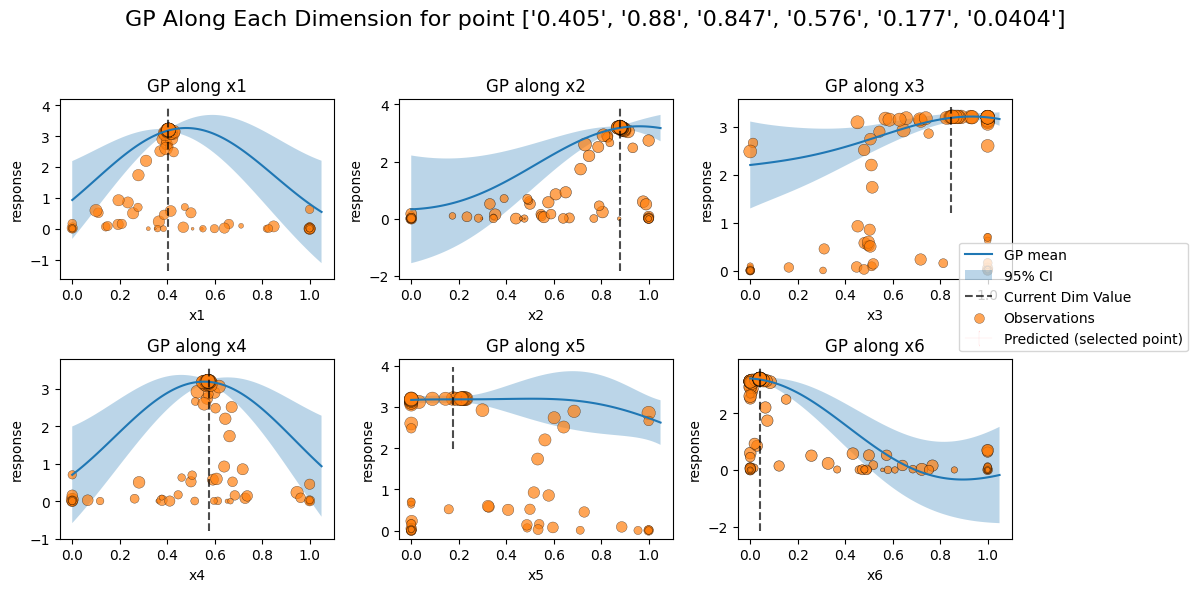

In [ ]:
def noise_fn(x):
    return x

save_dir = "data/bayes_sim/"
runs = tester.run(SingleTaskGP, n_runs=100, technical_repeats=1, batch_size=1, noise_fn=noise_fn, plot_each=False)
runs.plot_GP(SingleTaskGP)

## Noise vs technical repeats for sequential Single task GP
* SingleTaskGP
* qLogExpectedImprovement
* 100 sequential runs
* range [0, 3.4]
* Noise [0,2]
* Technical repeats: [1,8]

In [ ]:
explo_dict:dict = pickle.load(open(save_dir + r"singleGP_noise_vs_t_repeats.pkl", "rb"))

explo_dict

{(1,
  0.0):      trial_index        x1        x2        x3        x4        x5        x6  \
 0              0  0.500000  0.500000  0.500000  0.500000  0.500000  0.500000   
 1              1  0.068510  0.524321  0.633882  0.981709  0.268286  0.426622   
 2              2  0.702215  0.388755  0.159501  0.440739  0.967065  0.684298   
 3              3  0.843768  0.874021  0.812705  0.631410  0.620857  0.975607   
 4              4  0.477734  0.226613  0.353980  0.164573  0.178948  0.233771   
 ..           ...       ...       ...       ...       ...       ...       ...   
 96            96  0.201180  0.155828  0.484938  0.274519  0.312479  0.642830   
 97            97  0.000000  1.000000  0.000000  1.000000  0.480179  0.221057   
 98            98  0.202143  0.159567  0.488242  0.273558  0.308982  0.661451   
 99            99  0.000000  1.000000  0.000000  0.000000  0.000000  0.000000   
 100          100  0.000000  1.000000  1.000000  1.000000  0.470286  1.000000   
 
      response

In [ ]:
importlib.reload(ax_helper)
def get_top_deciles(explo_dict):
    return {id:ax_helper.get_above_percentile(df, 3.4, .9) for id, df in explo_dict.items()}

get_top_deciles(explo_dict)

{(1,
  0.0):      trial_index        x1        x2        x3        x4        x5        x6  \
 0              0  0.500000  0.500000  0.500000  0.500000  0.500000  0.500000   
 1              1  0.068510  0.524321  0.633882  0.981709  0.268286  0.426622   
 2              2  0.702215  0.388755  0.159501  0.440739  0.967065  0.684298   
 3              3  0.843768  0.874021  0.812705  0.631410  0.620857  0.975607   
 4              4  0.477734  0.226613  0.353980  0.164573  0.178948  0.233771   
 ..           ...       ...       ...       ...       ...       ...       ...   
 96            96  0.201180  0.155828  0.484938  0.274519  0.312479  0.642830   
 97            97  0.000000  1.000000  0.000000  1.000000  0.480179  0.221057   
 98            98  0.202143  0.159567  0.488242  0.273558  0.308982  0.661451   
 99            99  0.000000  1.000000  0.000000  0.000000  0.000000  0.000000   
 100          100  0.000000  1.000000  1.000000  1.000000  0.470286  1.000000   
 
      response

In [67]:
def hit_stats(hit_df):
    output_dict = {}
    for id, df in hit_df.items():

            
        wd = {
            "TP_index": df[df["assumed_hit"] & df["true_hit"]].index.tolist(),
            "FP_index": df[df["assumed_hit"] & ~df["true_hit"]].index.tolist(),
            "TN_index": df[~df["assumed_hit"] & ~df["true_hit"]].index.tolist(),
            "FN_index": df[~df["assumed_hit"] & df["true_hit"]].index.tolist(),
        }
    

        wd =  wd |{
            "TP": len(wd["TP_index"]),
            "FP": len(wd["FP_index"]),
            "TN": len(wd["TN_index"]),
            "FN": len(wd["FN_index"]),
        }

        total = wd["TP"] + wd["FP"] + wd["TN"] + wd["FN"]

        def sdiv(num, den):
            return num / den if den != 0 else 0.0

        wd = wd | {
            "Precision": sdiv(wd["TP"], wd["TP"] + wd["FP"]),
            "Recall": sdiv(wd["TP"], wd["TP"] + wd["FN"]),
            "Specificity": sdiv(wd["TN"], wd["TN"] + wd["FP"]),
            "Accuracy": sdiv(wd["TP"] + wd["TN"], total),
        }
        output_dict[id] = wd


    return output_dict


hits = hit_stats(get_top_deciles(explo_dict))
hits

{(1,
  0.0): {'TP_index': [34,
   35,
   36,
   37,
   38,
   40,
   41,
   43,
   44,
   45,
   47,
   49,
   52,
   66,
   74,
   80,
   87,
   88,
   96,
   98], 'FP_index': [], 'TN_index': [0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33,
   39,
   42,
   46,
   48,
   50,
   51,
   53,
   54,
   55,
   56,
   57,
   58,
   59,
   60,
   61,
   62,
   63,
   64,
   65,
   67,
   68,
   69,
   70,
   71,
   72,
   73,
   75,
   76,
   77,
   78,
   79,
   81,
   82,
   83,
   84,
   85,
   86,
   89,
   90,
   91,
   92,
   93,
   94,
   95,
   97,
   99,
   100], 'FN_index': [], 'TP': 20, 'FP': 0, 'TN': 81, 'FN': 0, 'Precision': 1.0, 'Recall': 1.0, 'Specificity': 1.0, 'Accuracy': 1.0},
 (1,
  0.2): {'TP_index': [39,
   63,
   64,
   65,
   66,
   67,
   68,
   69,
   70,
   71,
   72,
   73,
   74,
   77,
   